In [1]:
import pandas as pd
import numpy as np
import sqlite3
import gspread
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

/Users/wenxixia/opt/anaconda3/lib/python3.8/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
pwd

'/Users/wenxixia/git-intro/UCB-MFE-python-preprogram/Lectures/Lecture 4'

In [3]:
def calc_vol(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

def calc_ret(df):
    return df.close/df.close.shift(1)-1

def calc_mdd(df):
    ser = df.close
    return np.maximum.accumulate((np.maximum.accumulate(ser)-ser)/np.maximum.accumulate(ser))

def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

    if events is not None:
        ymin, ymax = ax.get_ylim()
        text_pos = 1
        
        for idx, row in events.loc[data.index[0]:data.index[-1]].iterrows():
            if row.impact == 1:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.2', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.2')    
            elif row.impact == 2:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.6', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.6')
                


In [4]:
token = 'BTC'
start_date = '2021-11-05'
end_date = '2021-11-11'
connection_string = 'sqlite:///data/data.db'

In [5]:
# Parameters
start_date = "2021-11-05"
end_date = "2021-11-11"
token = "ATOM"
connection_string = "sqlite:////Users/wenxixia/git-intro/UCB-MFE-python-preprogram/Lectures/Lecture 4/data/data.db"


In [6]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{start_date}'
    AND ts < '{end_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)
prices['return'] = calc_ret(prices)
prices['volatility'] = calc_vol(prices)
prices['maxdropdown'] = calc_mdd(prices)

In [7]:
prices

,open,high,low,close,volume,volumeUSD,token,chain,return,volatility,maxdropdown
ts,,,,,,,,,,,
2021-11-05 00:00:00,37.088,37.574,37.038,37.529,51222.3,1.914474e+06,ATOM,ATOM,NaN,NaN,0.000000
2021-11-05 01:00:00,37.536,37.537,36.627,36.674,51231.6,1.899128e+06,ATOM,ATOM,-0.022782,NaN,0.022782
2021-11-05 02:00:00,36.670,37.700,36.636,37.501,43716.4,1.629224e+06,ATOM,ATOM,0.022550,NaN,0.022782
2021-11-05 03:00:00,37.500,38.038,37.460,37.877,49970.2,1.888585e+06,ATOM,ATOM,0.010026,NaN,0.022782
2021-11-05 04:00:00,37.874,38.672,37.867,38.561,103379.9,3.960998e+06,ATOM,ATOM,0.018058,NaN,0.022782
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10 19:00:00,36.698,36.727,35.811,35.925,326180.5,1.182898e+07,ATOM,ATOM,-0.021064,0.155490,0.100795
2021-11-10 20:00:00,35.923,36.145,34.500,34.600,201016.0,7.165931e+06,ATOM,ATOM,-0.036882,0.193885,0.107143
2021-11-10 21:00:00,34.617,34.679,32.650,33.318,456178.6,1.536600e+07,ATOM,ATOM,-0.037052,0.268940,0.140225


In [8]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
series_plot(prices[['return']], ax=ax[0, 0])
series_plot(prices[['volatility']],  ax=ax[0, 1])
series_plot(prices[['maxdropdown']],  ax=ax[1, 0])
series_plot(prices[['close']],  ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {start_date} and {end_date}')
fig

fig

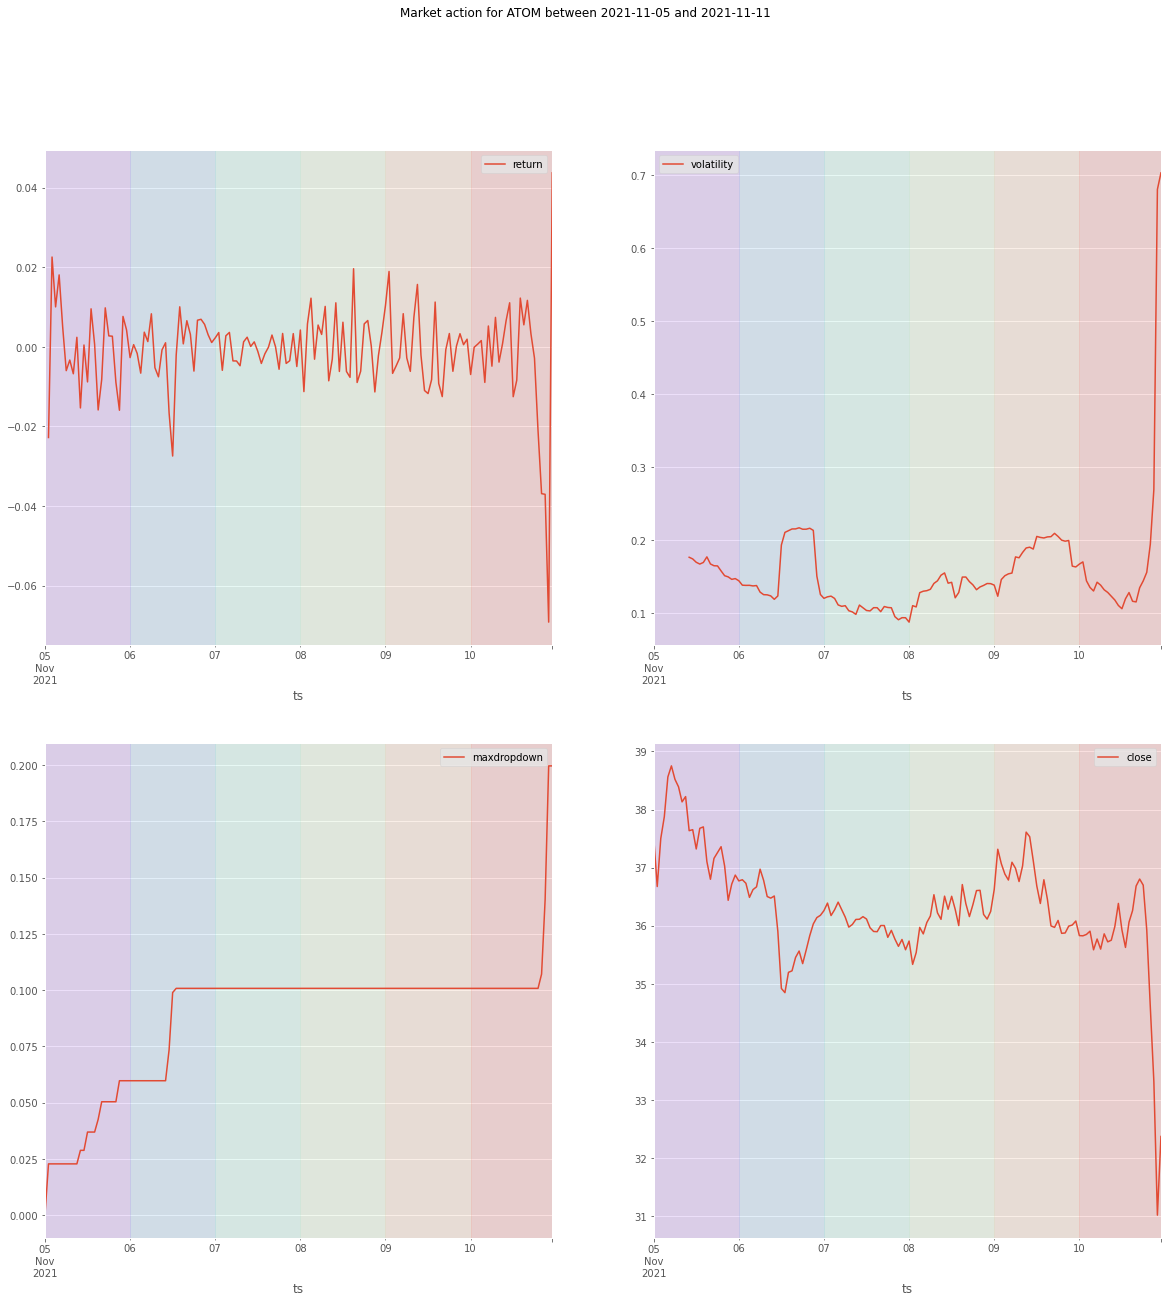

In [9]:
sb.glue('token', token)
sb.glue('from_date', start_date)
sb.glue('to_date', end_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)